<a href="https://colab.research.google.com/github/jeeyalal/Variational-Autoregression/blob/main/Var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import tensorflow as tf

import keras

from keras import layers

In [2]:
class Sampling(layers.Layer):

    """Uses (mean, log_var) to sample z, the vector encoding a digit."""


    def call(self, inputs):

        mean, log_var = inputs

        batch = tf.shape(mean)[0]

        dim = tf.shape(mean)[1]

        epsilon = tf.random.normal(shape=(batch, dim))

        return mean + tf.exp(0.5 * log_var) * epsilon

In [3]:
latent_dim = 2


encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)

x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)

x = layers.Dense(16, activation="relu")(x)

mean = layers.Dense(latent_dim, name="mean")(x)

log_var = layers.Dense(latent_dim, name="log_var")(x)

z = Sampling()([mean, log_var])

encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 128)            73856     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 6272)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)

x = layers.Reshape((7, 7, 64))(x)

x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       73856     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         577 

In [5]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):

        super().__init__(**kwargs)

        self.encoder = encoder

        self.decoder = decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

        self.reconstruction_loss_tracker = keras.metrics.Mean(

            name="reconstruction_loss"

        )

        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property

    def metrics(self):

        return [

            self.total_loss_tracker,

            self.reconstruction_loss_tracker,

            self.kl_loss_tracker,

        ]


    def train_step(self, data):

        with tf.GradientTape() as tape:

            mean,log_var, z = self.encoder(data)

            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(

                tf.reduce_sum(

                    keras.losses.binary_crossentropy(data, reconstruction),

                    axis=(1, 2),

                )

            )

            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        self.kl_loss_tracker.update_state(kl_loss)

        return {

            "loss": self.total_loss_tracker.result(),

            "reconstruction_loss": self.reconstruction_loss_tracker.result(),

            "kl_loss": self.kl_loss_tracker.result(),

        }

In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

fashion_mnist = np.concatenate([x_train, x_test], axis=0)

fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255


vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(fashion_mnist, epochs=1, batch_size=12)

5834/5834 [==============================] - 362s 61ms/step - loss: 330.7203 - reconstruction_loss: 306.5859 - kl_loss: 5.5635


1875/1875 [==============================] - 24s 13ms/step


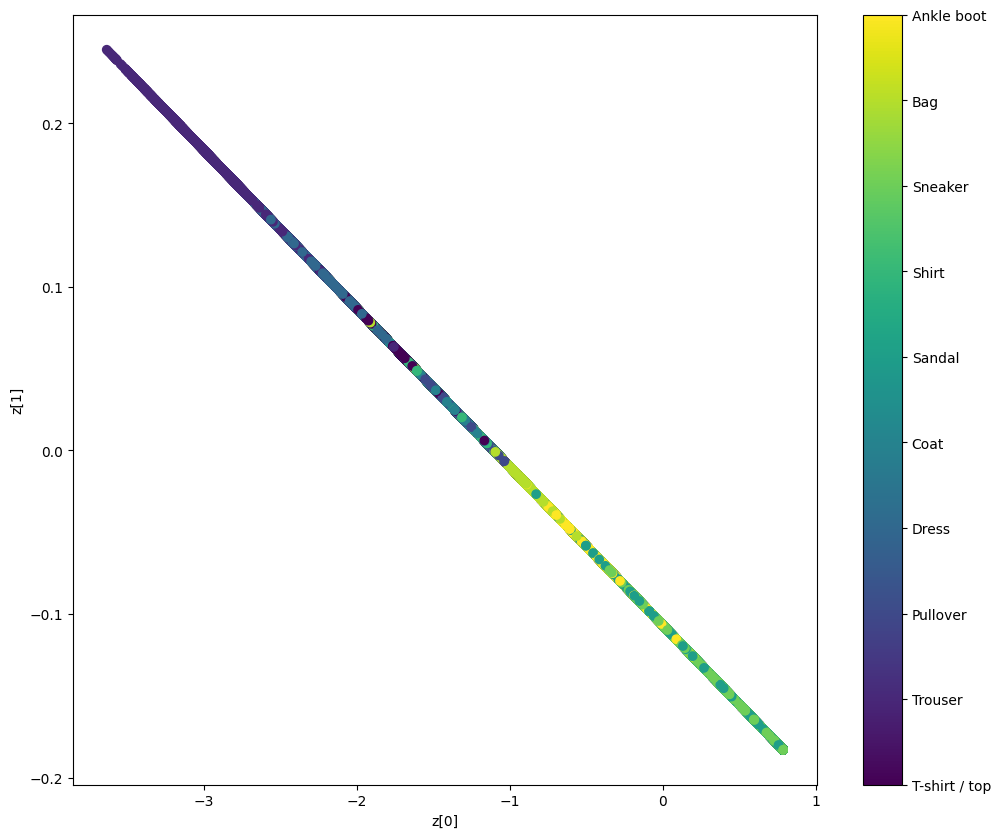

In [8]:
import matplotlib.pyplot as plt
def plot_label_clusters(encoder, decoder, data, test_lab):

    z_mean, _, _ = encoder.predict(data)

    plt.figure(figsize =(12, 10))

    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)

    cbar = plt.colorbar(sc, ticks = range(10))

    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])

    plt.xlabel("z[0]")

    plt.ylabel("z[1]")

    plt.show()



labels = {0    :"T-shirt / top",

1:    "Trouser",

2:    "Pullover",

3:    "Dress",

4:    "Coat",

5:    "Sandal",

6:    "Shirt",

7:    "Sneaker",

8:    "Bag",

9:    "Ankle boot"}


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)